# Get started on the "Air Quality & Health" AI4EO challenge

The notebook will get you started exploring and analysing the input and output data of the challenge. 

The aim of the challenge is to produce NO2 and PM2.5 maps at an improved spatial resolution using CAMS forecasts, Sentinel-5P measurements and auxiliary data sources. The minimum target spatial resolutions are as follows:

 * NO2 `1km x 1km` for all three AOIs, i.e. Italy, California, South Africa;
 * PM2.5 `1km x 1km` for Italy;
 * PM2.5 `10km x 10km` for California and South Africa.

This notebook showcases how to read and process the data using [eo-learn](https://eo-learn.readthedocs.io/en/latest/), a Python library designed to read and process Earth Observation data. You can use any other Python tool of preference to read and process the provided data.

As per challenge rules, no data source other than the ones provided can be used to produce your outputs. Code for the winning solutions will be reviewed to ensure rules have been followed. 

The content of the notebook is as follows:

1. [Data Sources](#data-sources)

   1.1. [Reference Ground Air Quality](#ground-air-quality)
     * [NO2](#reference-no2)     
     * [PM2.5](#reference-pm25)
     
   1.2. [Input data](#input-data)
     * [Copernicus Atmospheric Monitoring Service](#cams)
     * [Sentinel-5P](#sentinel-5p)
    
   1.3. [Auxiliary data](#auxiliary-data) 
     * [Land Cover](#land-cover)
     * [Digital Elevation Model](#dem)
     * [ERA5](#era5)
     * [Sentinel-3](#sentinel-3)
     * [MODIS](#modis)
        
2. [Pre-processing](#pre-processing)

3. [Submission example](#submission-example)

   3.1 [Prepare a submission](#prepare-a-submission)


If you are an AI expert and are not familiar with EO datasets, but would like to get an analysis-ready dataset, consult the [Pre-processing](#pre-processing) Section on how to get started, or open a post in our forum so we can help you out. There will be many EO experts taking part in the challenge looking for an AI expert, so make sure to get in touch!!

In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1790m7nq because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)

#### Set up paths and constants

Change this for the three provided AOIs. The data sources and data structure is consistent across AOIs. The AOIs are as follows:

 * `training_dataset_ita` - `Italy`
 * `training_dataset_usa` - `California`
 * `training_dataset_south_africa` - `South_Africa`

In [3]:
DATA_DIR = Path('training_dataset_ita')
AOIS = ['Italy']

To anonimise the actual acquisition dates, a fictitious Julian day is assigned to each acquisition. Since datetimes are required to process datasets in `EOPatches`, a fictitious datetime is generated converting the Julian day to a Day of Year (DOY) by setting an offset. 

Help functions to convert from days to datetimes are provided (e.g. `days_to_datetime` and `datetime_to_days`).

In [4]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

Overview of the data structure.

In [5]:
filesystem = fs.open_fs(str(DATA_DIR))
filesystem.tree(with_color=True, max_levels=1)

└── Italy
    ├── CAMS
    ├── corine
    ├── era5
    ├── ground_air_quality
    ├── modis_MCD19A2
    ├── SEN3
    ├── sentinel5P
    ├── eu_dem_v11_North_Italy.tif
    └── eu_dem_v11_North_Italy.zip


## 1. Data sources <a name="data-sources"></a>

In [6]:
data_sources = os.listdir(DATA_DIR/AOIS[0])
data_sources

['ground_air_quality',
 'corine',
 'eu_dem_v11_North_Italy.tif',
 'era5',
 'modis_MCD19A2',
 'SEN3',
 'eu_dem_v11_North_Italy.zip',
 'sentinel5P',
 'CAMS']

### 1.1. Reference ground air quality <a name="ground-air-quality"></a>

These datasets provide the reference "ground-truth" to be used as target in your super-resolution solution. The datasets were collected from ground stations measuring both NO2 and PM2.5 levels at a given day.

#### 1.1.1. Nitrogen Dioxide (NO2) <a name="reference-no2"></a>

The file contains the coordinates of the ground stations, the date of the measurement, and the value of the measurement.

In [7]:
no2_gt = gpd.read_file(str(DATA_DIR/AOIS[0]/'ground_air_quality'/'NO2'/'NO2_italy_ground.shp'))
no2_gt.head()

,Date,SITE_LATIT,SITE_LONGI,AirQuality,geometry
0,2336,45.5829,8.83449,56.2,POINT (8.83449 45.58290)
1,2314,45.5829,8.83449,37.7,POINT (8.83449 45.58290)
2,2329,45.5829,8.83449,43.2,POINT (8.83449 45.58290)
3,2294,45.5829,8.83449,23.2,POINT (8.83449 45.58290)
4,2295,45.5829,8.83449,31.3,POINT (8.83449 45.58290)


Check unique dates

In [8]:
np.sort(no2_gt.Date.unique())

array([2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304,
       2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315,
       2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326,
       2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337,
       2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348,
       2349, 2350, 2351, 2352, 2353, 2355, 2356, 2357, 2358, 2359, 2360,
       2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371,
       2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381])

Find unique locations grouping by geometry

In [9]:
no2_gt['geometry_wkt'] = no2_gt['geometry'].apply(lambda geom: geom.wkt) 
no2g_gt = no2_gt.groupby(['SITE_LATIT', 'SITE_LONGI'])

no2_gt_min = no2g_gt.min()
no2_gt_min['geometry'] = no2_gt_min['geometry_wkt'].apply(lambda x: wkt.loads(x))
no2_gt_min.drop(columns='geometry_wkt', inplace=True)
no2_gt_min.head()

,,Date,AirQuality,geometry
SITE_LATIT,SITE_LONGI,,,
43.5200,10.3217,2294,2.9,POINT (10.32170 43.52000)
43.5547,10.3297,2294,14.9,POINT (10.32970 43.55470)
43.5689,10.3327,2294,6.0,POINT (10.33270 43.56890)
43.7139,10.4106,2294,14.2,POINT (10.41060 43.71390)
43.7389,10.4017,2294,8.4,POINT (10.40170 43.73890)


Coordinates of unique locations

In [10]:
no2_gt_min.index.values

array([(43.52, 10.3217), (43.5547, 10.3297), (43.5689, 10.3327),
       (43.7139, 10.4106), (43.7389, 10.4017), (43.7731, 11.2722),
       (43.7858, 11.2314), (43.7867, 11.2875), (43.8728, 11.0919),
       (43.8747, 11.1053), (43.8839, 10.245), (44.0311, 10.1328),
       (44.0522, 12.5756), (44.0625, 12.5533), (44.0783, 10.0972),
       (44.215, 12.0564), (44.2192, 12.0489), (44.42, 12.2256),
       (44.4286, 12.1867), (44.4833, 11.355), (44.4997, 11.3283),
       (44.5, 11.2861), (44.636, 10.9047), (44.6506, 10.9063),
       (44.6908, 10.6647), (44.7003, 10.6228), (44.7883, 10.3367),
       (44.7936, 10.3317), (44.825, 11.6497), (44.8425, 11.6131),
       (44.8942, 8.1975), (44.9089, 8.2055), (45.0249, 7.6491),
       (45.0383, 9.66917), (45.0419, 7.6259), (45.0489, 9.69333),
       (45.0758, 7.6782), (45.1041, 7.69534), (45.1328, 10.0167),
       (45.1422, 10.0458), (45.1856, 9.14694), (45.1939, 9.16472),
       (45.3044, 8.84583), (45.3719, 11.8419), (45.3953, 9.28278),
       (45.4

Number of unique locations, and number of measurements for each location

In [11]:
len(no2_gt_min.index.values), no2g_gt.size().values

(92,
 array([ 87,  87,  81,  87,  87,  79,  86,  84,  85,  86,  84,  86,  80,
         79,  85,  69,  85,  77,  87,  85,  86,  85,  87,  87,  87,  84,
         87,  87,  87,  87,  87,  81,  86,  87,  87,  87,  87,  78,  87,
         87,  85,  87,  87,  87,  85,  87,  87,  60,  27,  87,  86,  78,
         87,  87,  85,  87,  60,  83,  87,  76,  75,  83,  59,  87,  87,
         83,  87,  74,  79,  87,  87,  84,  79,  69,  87,  87,  84,  87,
         83,  87,  87,  87, 166,  87,  87,  25,  55,  87,  87,  85,  84,
         85]))

Visualise locations

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

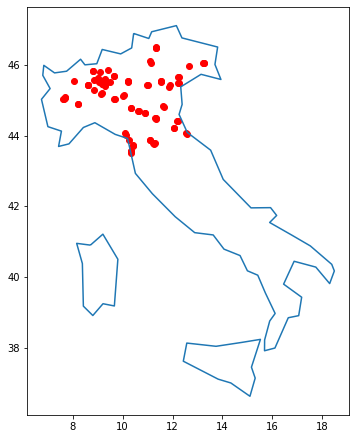

In [13]:
fig, ax = plt.subplots(figsize=(15,7.5))

world[world.name == AOIS[0]].boundary.plot(ax=ax)

no2_gt_min.plot(ax=ax, color='r', figsize=(15,7.5), marker='o')

#### 1.1.2. Particulate Matter 2.5 (PM2.5) <a name="reference-pm25"></a>

The file contains the coordinates of the ground stations, the date of the measurement, and the value of the measurement.

In [14]:
pm25_gt = gpd.read_file(str(DATA_DIR/AOIS[0]/'ground_air_quality'/'PM25'/'PM25_italy_ground.shp'))
pm25_gt.head()

,Date,SITE_LATIT,SITE_LONGI,AirQuality,geometry
0,2294,45.5588,8.0564,5.0,POINT (8.05640 45.55880)
1,2295,45.5588,8.0564,5.0,POINT (8.05640 45.55880)
2,2296,45.5588,8.0564,5.0,POINT (8.05640 45.55880)
3,2297,45.5588,8.0564,9.0,POINT (8.05640 45.55880)
4,2298,45.5588,8.0564,7.0,POINT (8.05640 45.55880)


In [15]:
pm25_gt['geometry_wkt'] = pm25_gt['geometry'].apply(lambda geom: geom.wkt) 
pm25g_gt = pm25_gt.groupby(['SITE_LATIT', 'SITE_LONGI'])

pm25_gt_min = pm25g_gt.min()
pm25_gt_min['geometry'] = pm25_gt_min['geometry_wkt'].apply(lambda x: wkt.loads(x))
pm25_gt_min.drop(columns='geometry_wkt', inplace=True)
pm25_gt_min.head()

,,Date,AirQuality,geometry
SITE_LATIT,SITE_LONGI,,,
43.5200,10.3217,2294,2.0,POINT (10.32170 43.52000)
43.5547,10.3297,2294,4.0,POINT (10.32970 43.55470)
43.7139,10.4106,2294,6.0,POINT (10.41060 43.71390)
43.7389,10.4017,2294,5.0,POINT (10.40170 43.73890)
43.7731,11.2722,2294,5.0,POINT (11.27220 43.77310)


Number of unique locations, and number of measurements for each location

In [16]:
len(pm25_gt_min.index.values), pm25g_gt.size().values

(50,
 array([86, 85, 86, 83, 84, 84, 82, 84, 87, 86, 67, 83, 81, 83, 86, 86, 87,
        86, 87, 84, 84, 74, 84, 87, 85, 86, 74, 87, 57, 27, 86, 83, 87, 80,
        59, 71, 79, 87, 58, 86, 87, 83, 87, 87, 87, 72, 86, 87, 26, 57]))

NOTE: different number of locations available for NO2 and PM2.5

<AxesSubplot:>

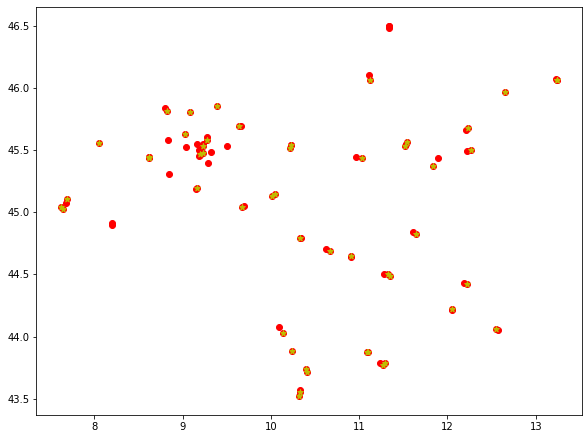

In [17]:
fig, ax = plt.subplots(figsize=(15,7.5))

no2_gt_min.plot(ax=ax, color='r', marker='o')
pm25_gt_min.plot(ax=ax, color='y', marker='*')

Plot the time-series for the pollutants for a location

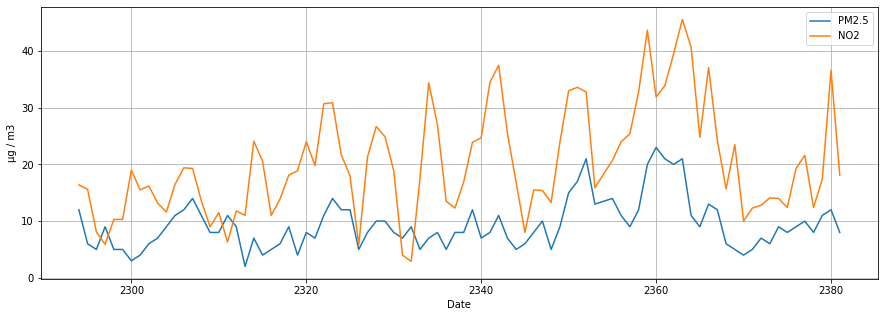

In [18]:
no2_example = no2g_gt.get_group((  43.52, 10.3217)).sort_values(by=['Date'])[['Date','AirQuality']]
pm25_example = pm25g_gt.get_group((  43.52, 10.3217)).sort_values(by=['Date'])[['Date','AirQuality']]

fig, ax = plt.subplots(figsize=(15,5))
pm25_example.plot(ax=ax, x='Date', y='AirQuality', label='PM2.5')
no2_example.plot(ax=ax, x='Date', y='AirQuality', label='NO2')
ax.grid()
ax.set_ylabel('μg / m3');

### 1.2 Input data <a name="input-data"></a>

These data will be used as input to your model to generate NO2 and PM2.5 maps at the given improved spatial resolution. The input data has coarser spatial resolution and/or affected by missing information. For this reason, auxiliary data is provided to  compensate for these short-comings.

#### 1.2.1 Copernicus Atmospheric Monitoring Service data (CAMS) <a name="cams"></a>

These products are provided by the [European Centre for Medium-Range Weather Forecast (ECMRWF)](https://www.ecmwf.int/). These datasets provide daily forecasts of many anthropogenic and natural emissions. You can find more information about CAMS products [here](https://www.regional.atmosphere.copernicus.eu/).


In [19]:
cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'

cams_products = sorted(os.listdir(cams_train_dir))
cams_products

['NO2_surface', 'PM2_5']

Load tiffs as `EOPatch`es, with provided `OFFSET`. This will results in loading the data into separate `EOPatch`es, where the info about the bounding box, timestamps and arrays can be found.

NOTE the fictitious datetimes.

In [20]:
cams_eops = [load_tiffs(cams_train_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

cams_eops

[EOPatch(
   data: {
     NO2_surface: numpy.ndarray(shape=(2208, 45, 65, 1), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.09999994855178, 42.60000146110102), (13.599999459166277, 47.10000081332225)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=2208
 ),
 EOPatch(
   data: {
     PM2_5: numpy.ndarray(shape=(2208, 45, 65, 1), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.09999994855178, 42.60000146110102), (13.599999459166277, 47.10000081332225)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=220

Since both products share the same bounding box, timestamps and spatial resolution, they can be merged into a single `EOPatch`, easing the following post-processing.

In [21]:
cams_eop = EOPatch(data={'NO2_surface': cams_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_eops[1].data['PM2_5']},
                     timestamp=cams_eops[0].timestamp,
                     bbox=cams_eops[0].bbox)
del cams_eops
cams_eop

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(2208, 45, 65, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(2208, 45, 65, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((7.09999994855178, 42.60000146110102), (13.599999459166277, 47.10000081332225)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=2208
)

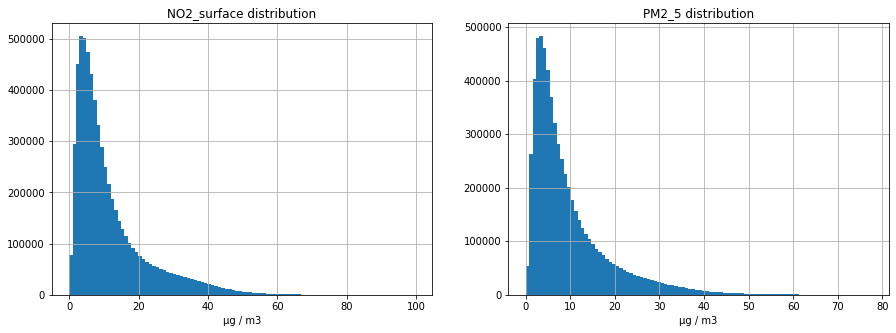

In [22]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=len(cams_products))

for icamsp , camsp in enumerate(cams_products):
    axs[icamsp].hist(cams_eop.data[camsp].ravel(), bins=100);
    axs[icamsp].grid()
    axs[icamsp].set_title(f'{camsp} distribution')
    axs[icamsp].set_xlabel('μg / m3')

Visualise some examples, selecting the index of the timestamp to visualise as `time_idx`.

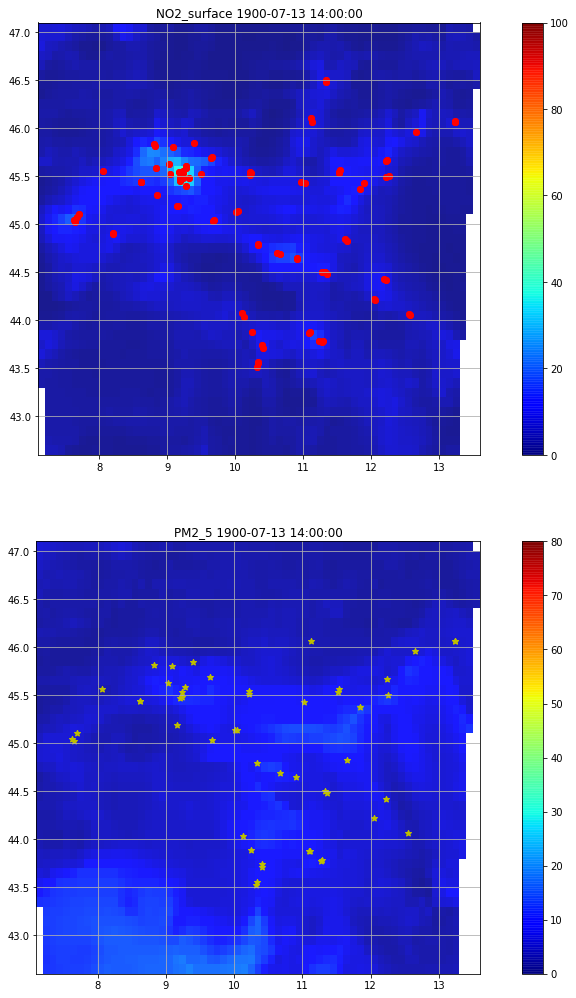

In [23]:
fig, axs = plt.subplots(figsize=(15, 17.5), nrows=len(cams_products))

time_idx = 14

normalisations = [dict(vmin=0, vmax=100), 
                  dict(vmin=0, vmax=80)]

for nn, (fname, norm) in enumerate(zip(cams_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=cams_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])
    
    no2_gt_min.plot(ax=axs[0], color='r', marker='o')
    pm25_gt_min.plot(ax=axs[1], color='y', marker='*')

#### 1.2.2 Sentinel-5P products <a name="sentinel-5p"></a>



The following products for the Sentinel-5P are provided:

 * [`NO2`](http://www.tropomi.eu/data-products/nitrogen-dioxide): NO2 tropospheric column measurements at daily revisit, with a spatial resolution of `7 x 7 km`. This product will be used as input to the AI model to estimate the upscaled NO2 map;
 * [`UV_AEROSOL_INDEX`](http://www.tropomi.eu/data-products/uv-aerosol-index): The UV Aerosol index helps tracking the evolution of episodic aerosol plumes from dust outbreaks, volcanic ash, and biomass burning.
 
Both products include a Quality assurance value, that estimates the quality of the observations. Check-out this [document](https://sentinel.esa.int/documents/247904/3541451/Sentinel-5P-Nitrogen-Dioxide-Level-2-Product-Readme-File) for recommendations on how to set the `qa_value` for NO2.

NOTE: for the South African AOI, a different number of acquisitions is available for the 2 Sentinel-5 products.

In [24]:
s5p_train_dir = DATA_DIR/AOIS[0]/'sentinel5P'

s5p_products = sorted(os.listdir(s5p_train_dir))
s5p_products

['NO2', 'UV_AEROSOL_INDEX']

Ingest data into `EOPatch`

In [25]:
s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]
s5p_eops

[EOPatch(
   data: {
     NO2: numpy.ndarray(shape=(159, 71, 103, 2), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.071965933074978, 42.616631322326654), (13.548605933074981, 47.081111322326656)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 10, 0), ..., datetime.datetime(1900, 10, 12, 12, 0)], length=159
 ),
 EOPatch(
   data: {
     UV_AEROSOL_INDEX: numpy.ndarray(shape=(159, 71, 103, 2), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.071965933074978, 42.616631322326654), (13.548605933074981, 47.081111322326656)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 10, 0), ..., datetime.datetime(1900, 10, 12, 12, 0)], 

Merge features into a single `EOPatch` if they don't have same number of acquisitions

In [26]:
s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                 timestamp=s5p_eops[0].timestamp,
                 bbox=s5p_eops[0].bbox)
del s5p_eops
s5p_eop

EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(159, 71, 103, 2), dtype=float32)
    UV_AEROSOL_INDEX: numpy.ndarray(shape=(159, 71, 103, 2), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((7.071965933074978, 42.616631322326654), (13.548605933074981, 47.081111322326656)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 7, 13, 10, 0), ..., datetime.datetime(1900, 10, 12, 12, 0)], length=159
)

Set no valid data to `np.nan`

In [27]:
s5p_eop.data['NO2'][s5p_eop.data['NO2'] == NO_DATA_VALUE] = np.nan
s5p_eop.data['UV_AEROSOL_INDEX'][s5p_eop.data['UV_AEROSOL_INDEX'] == NO_DATA_VALUE] = np.nan

From the following histograms you can notice that some observations have a quality assurance value equal to `0`, causing invalid values in the measured values.

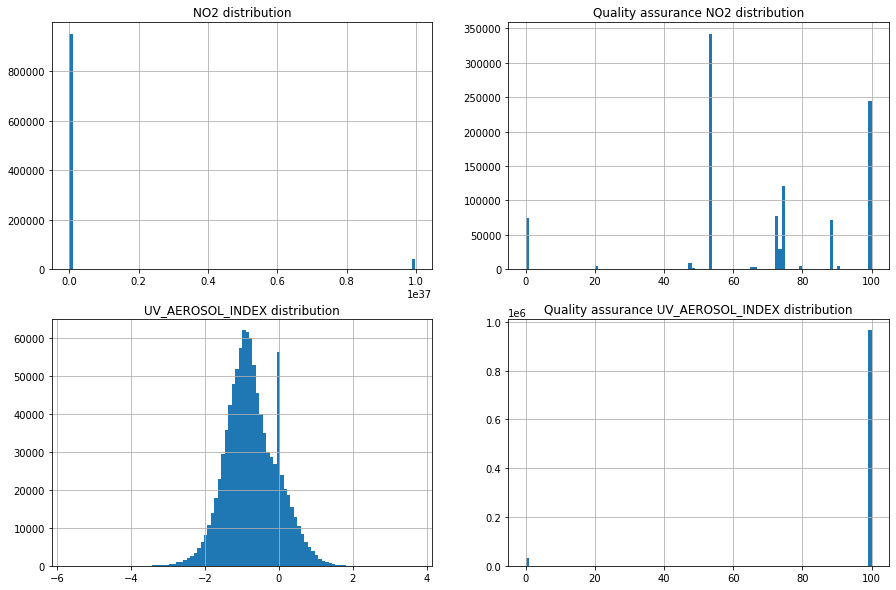

In [28]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=len(s5p_products), nrows=2)

for is5pp , s5pp in enumerate(s5p_products):
    axs[is5pp][0].hist(s5p_eop.data[s5pp][..., 0].ravel(), bins=100);
    axs[is5pp][0].grid()
    axs[is5pp][0].set_title(f'{s5pp} distribution')

    axs[is5pp][1].hist(s5p_eop.data[s5pp][..., 1].ravel(), bins=100);
    axs[is5pp][1].grid()
    axs[is5pp][1].set_title(f'Quality assurance {s5pp} distribution')

Use Qa band to reduce noisy observations. Higher values of Qa threshold would result in less noisy measurements. Try it changing `min_q_a`.

In [29]:
min_q_a = 50

for s5pp in s5p_products:
    s5p_eop.data[s5pp][..., 0][s5p_eop.data[s5pp][..., 1] <= min_q_a] = np.nan

You can now notice this effect by looking again at the distributions.

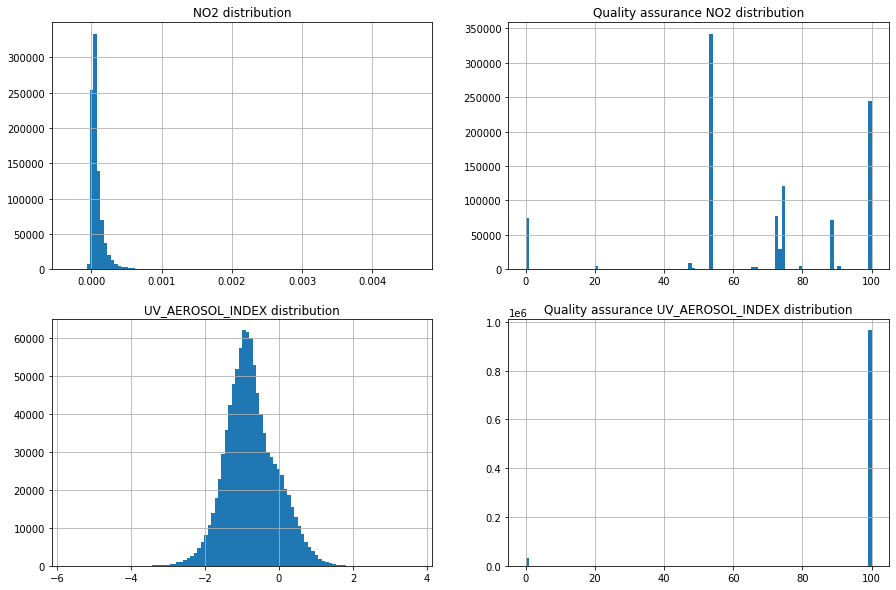

In [30]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=len(s5p_products), nrows=2)

for is5pp , s5pp in enumerate(s5p_products):
    axs[is5pp][0].hist(s5p_eop.data[s5pp][..., 0].ravel(), bins=100);
    axs[is5pp][0].grid()
    axs[is5pp][0].set_title(f'{s5pp} distribution')

    axs[is5pp][1].hist(s5p_eop.data[s5pp][..., 1].ravel(), bins=100);
    axs[is5pp][1].grid()
    axs[is5pp][1].set_title(f'Quality assurance {s5pp} distribution')

Some visual example. Feature values in the first columns, quality assurance values in the second. Ground station locations overlapped for reference.

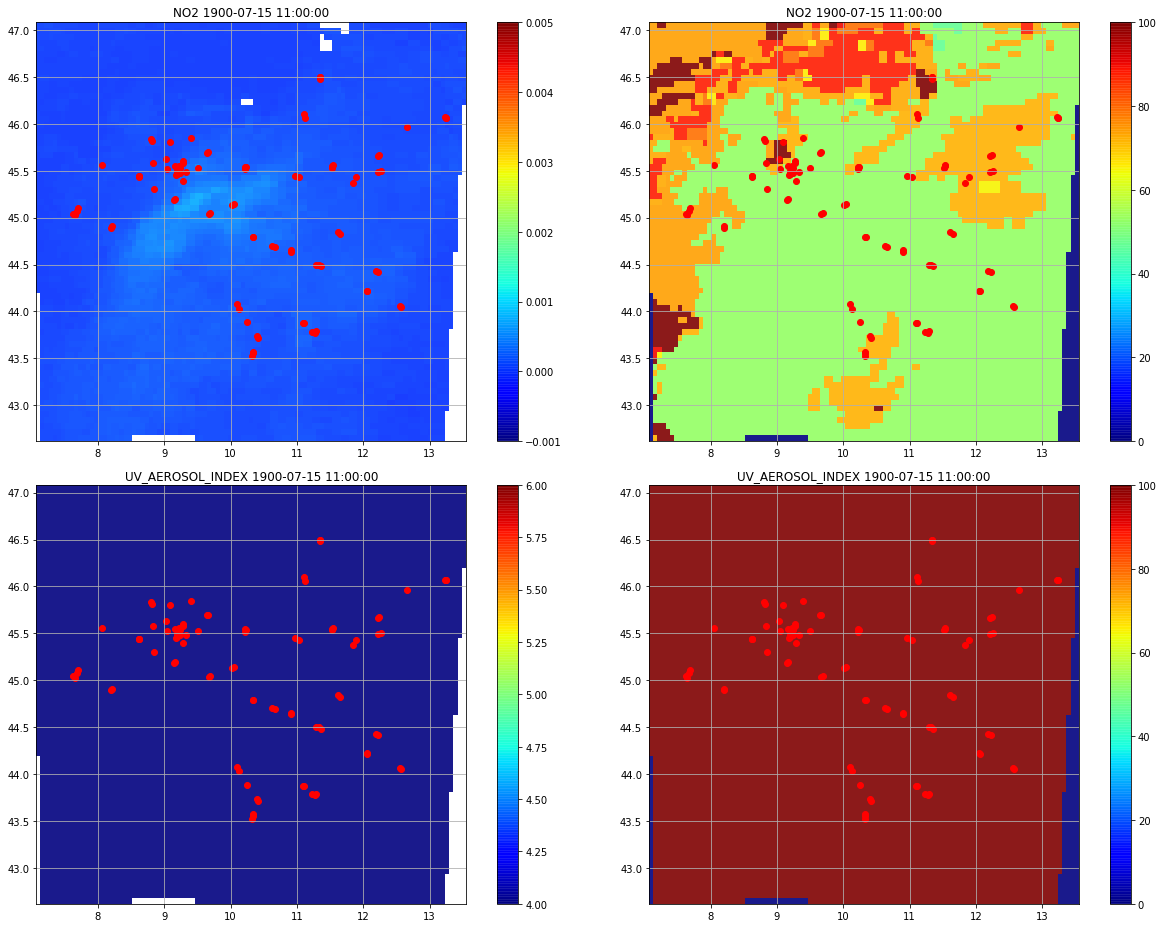

In [31]:
fig, axs = plt.subplots(figsize=(17.5, 13), nrows=len(s5p_products), ncols=2)

time_idx = 4

normalisations = [dict(vmin=-0.001, vmax=0.005), 
                  dict(vmin=6, vmax=4)]

for nn, (fname, norm) in enumerate(zip(s5p_products, normalisations)):
    # NO2 and UV_AEROSOL_INDEX
    fh = draw_feature(ax=axs[nn][0], eopatch=s5p_eop, 
                      feature=(FeatureType.DATA, fname), 
                      band=0,
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn][0])
    no2_gt_min.plot(ax=axs[nn][0], color='r', marker='o')
    
    # Q_a band in range [0, 100]
    fh = draw_feature(ax=axs[nn][1], eopatch=s5p_eop, 
                  feature=(FeatureType.DATA, fname), 
                  band=1,
                  time_idx=time_idx, 
                  vmin=0, vmax=100,
                  alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn][1])
    no2_gt_min.plot(ax=axs[nn][1], color='r', marker='o')
    
    fig.tight_layout();

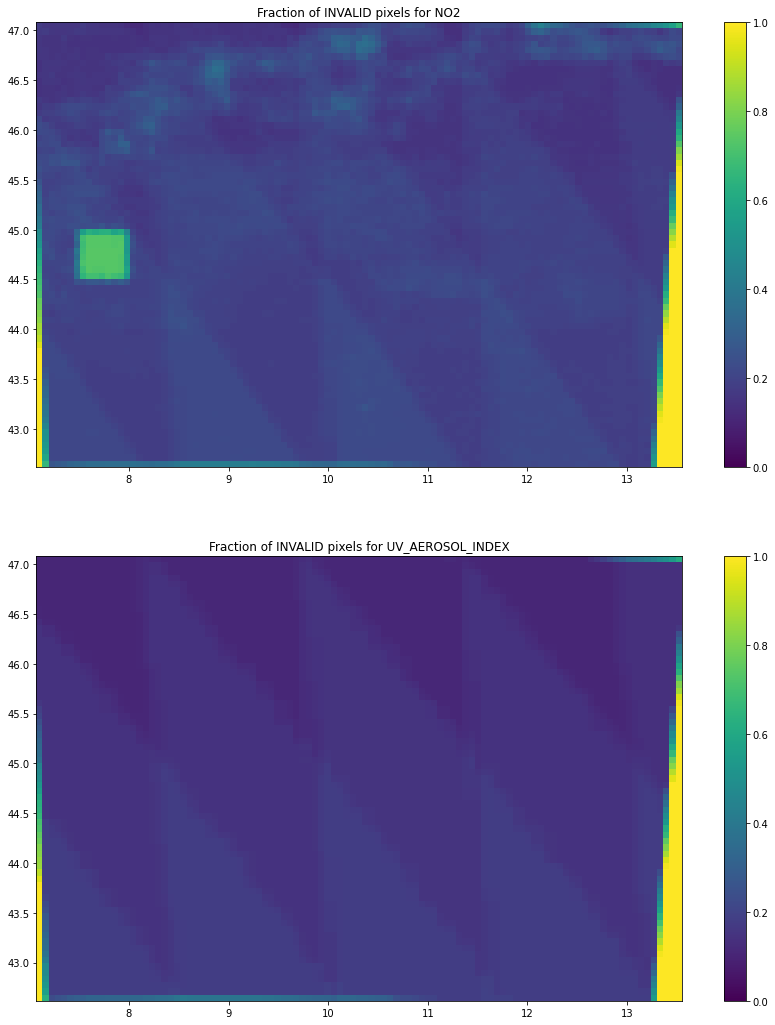

In [32]:
fig, axs = plt.subplots(figsize=(15,18), nrows=len(s5p_products))

for nn, fname in enumerate(s5p_products):
    fh = axs[nn].imshow(np.sum(np.isnan(s5p_eop.data[fname][..., 0]), 
                               axis=0).squeeze()/len(s5p_eop.timestamp), 
                        vmin=0, vmax=1, extent=get_extent(s5p_eop))
    axs[nn].set_title(f'Fraction of INVALID pixels for {fname}')
    
    fig.colorbar(fh, ax=axs[nn]);

Plot time-series at a given pixel location

NOTE the different units measured by different sensors.

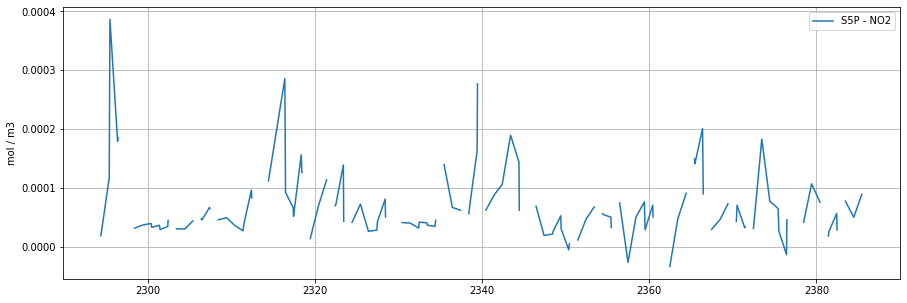

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(datetimes_to_days(s5p_eop.timestamp), 
        s5p_eop.data['NO2'][:, 57, 45, 0], label='S5P - NO2')
ax.grid();
ax.set_ylabel('mol / m3');
ax.legend();

### 1.3. Auxiliary data <a name="auxiliary-data"></a>

These data sources are provided to augment the information provided by CAMS and Sentinel-5P products. These data sources aim at representing important factors influencing air pollutants concentrations, such as land cover, metereological and topological information. 

#### 1.3.1. Land cover <a name="land-cover"></a>

For this AOI, the [Corine land cover](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018) is provided to characterise areas with human activity.

In [34]:
land_cover_train_dir = DATA_DIR/AOIS[0]/'corine'

txt_filename = land_cover_train_dir/'Legend'/'CLC2018_CLC2018_V2018_20_QGIS.txt'

In [35]:
land_cover_eop = load_tiffs(datapath=land_cover_train_dir,
                            feature=(FeatureType.MASK_TIMELESS, 'CORINE'), 
                            filename='U2018_CLC2018_V2020_20u1_North_Italy.tif',
                            image_dtype=np.uint8,
                            no_data_value=128)

# set no label value to 0
array = land_cover_eop.mask_timeless['CORINE']
land_cover_eop.mask_timeless['CORINE'][array==128] = 0

NOTE the different CRS for this data source

In [36]:
land_cover_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    CORINE: numpy.ndarray(shape=(5048, 5070, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((4088100.0, 2167100.0), (4595100.0, 2671900.0)), crs=CRS('3035'))
  timestamp: []
)

Parse the legend specifying each label in the map.

In [37]:
def parse_line(line):
    _, r, g, b, a, descr = line.split(',')
    return (int(r), int(g), int(b), int(a)), descr.split('\n')[0]

with open(txt_filename, 'r') as txtf:
    lines = txtf.readlines()

legend = {nline+1: parse_line(line) for nline, line in enumerate(lines[:-1])}
legend[0] = parse_line(lines[-1])

corine_cmap = ListedColormap([np.array(v[0])/255.0 for k, v in sorted(legend.items())])

In [38]:
for k, v in sorted(legend.items()):
    print(f'{k}:\t{v[1]}')

0:	NODATA
1:	Continuous urban fabric
2:	Discontinuous urban fabric
3:	Industrial or commercial units
4:	Road and rail networks and associated land
5:	Port areas
6:	Airports
7:	Mineral extraction sites
8:	Dump sites
9:	Construction sites
10:	Green urban areas
11:	Sport and leisure facilities
12:	Non-irrigated arable land
13:	Permanently irrigated land
14:	Rice fields
15:	Vineyards
16:	Fruit trees and berry plantations
17:	Olive groves
18:	Pastures
19:	Annual crops associated with permanent crops
20:	Complex cultivation patterns
21:	Land principally occupied by agriculture with significant areas of natural vegetation
22:	Agro-forestry areas
23:	Broad-leaved forest
24:	Coniferous forest
25:	Mixed forest
26:	Natural grasslands
27:	Moors and heathland
28:	Sclerophyllous vegetation
29:	Transitional woodland-shrub
30:	Beaches dunes sands
31:	Bare rocks
32:	Sparsely vegetated areas
33:	Burnt areas
34:	Glaciers and perpetual snow
35:	Inland marshes
36:	Peat bogs
37:	Salt marshes
38:	Salines
39:

Visualise the land cover map.

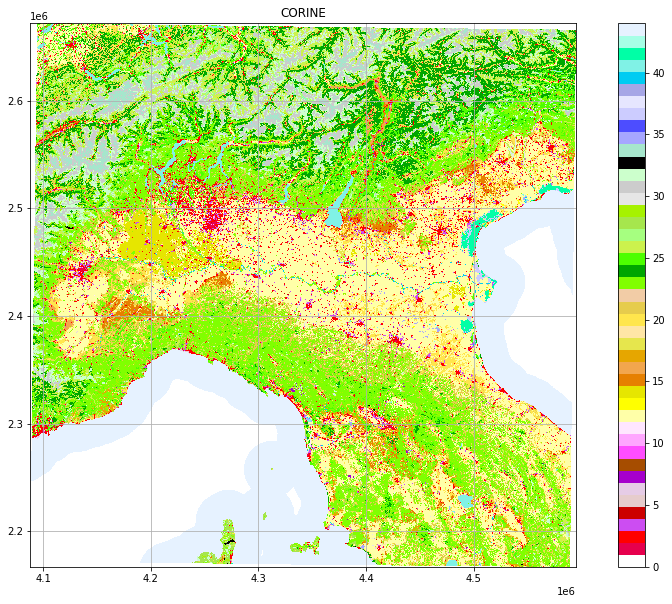

In [39]:
fig, ax = plt.subplots(figsize=(15,10))

fh = draw_feature(ax=ax, eopatch=land_cover_eop, 
                 feature=(FeatureType.MASK_TIMELESS, 'CORINE'), 
                 time_idx=None, 
                 vmin=0, vmax=44, cmap=corine_cmap)

fig.colorbar(fh, ax=ax);

#### 1.3.2. Digital Elevation Model <a name="dem"></a>

In [40]:
eu_dem_train_dir = DATA_DIR/AOIS[0]

eu_dem_eop = load_tiffs(eu_dem_train_dir, 
                        (FeatureType.DATA_TIMELESS, 'EU_DEM'),
                        filename='eu_dem_v11_North_Italy.zip')

In [41]:
eu_dem_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    EU_DEM: numpy.ndarray(shape=(20513, 21077, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((6.932533765, 42.554840711), (13.60973263, 47.161100966)), crs=CRS('4326'))
  timestamp: []
)

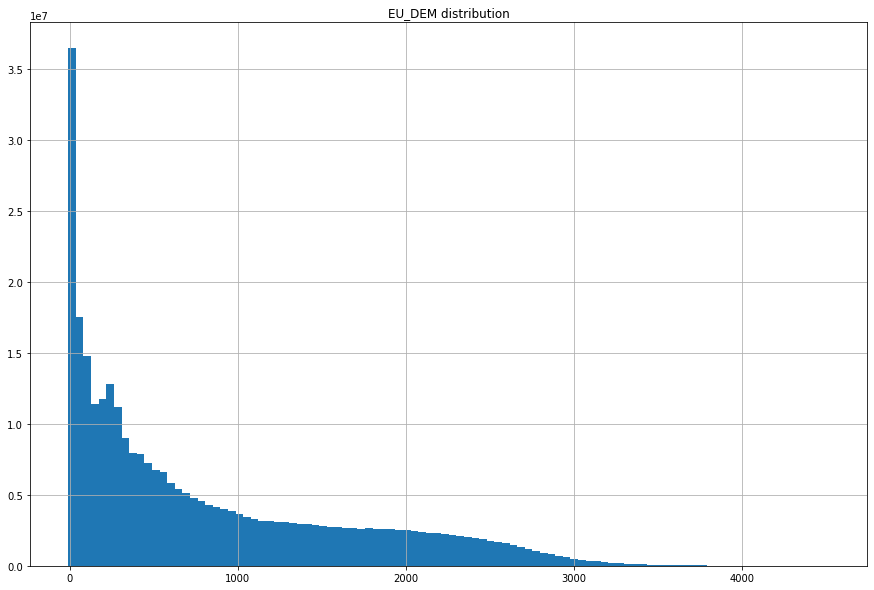

In [42]:
fig, axs = plt.subplots(figsize=(15, 10))

axs.hist(eu_dem_eop.data_timeless['EU_DEM'][..., 0].ravel(), bins=100);
axs.grid();
axs.set_title(f'EU_DEM distribution');

NOTE: The reference ground air stations are generally at low altitudes, which might make it hard to correctly estimate poluttants at high altitudes. You might want to take this into consideration. 

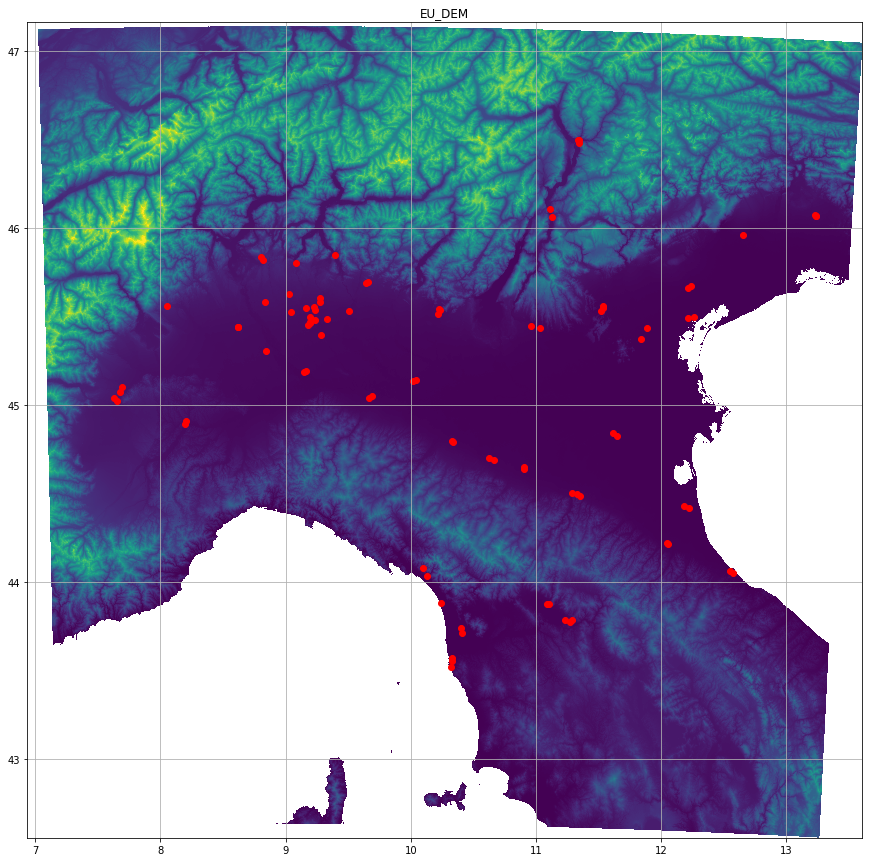

In [43]:
fig, ax = plt.subplots(figsize=(15,15))

draw_feature(ax=ax, eopatch=eu_dem_eop, 
             feature=(FeatureType.DATA_TIMELESS, 'EU_DEM'), 
             vmin=0, vmax=4000, cmap=plt.cm.viridis, time_idx=None);
no2_gt_min.plot(ax=ax, color='r', marker='o');

#### 1.3.3. ERA5 Metereological data <a name="era5"></a>

ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. These data are also [provided](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) by ECMWF, you can read more about these data in this [documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).

The datasets included in this challenge are the following:

 * [cropped_relative_humidity](https://apps.ecmwf.int/codes/grib/param-db?id=157)
 * [specific_rain_water_content](https://apps.ecmwf.int/codes/grib/param-db?id=75)
 * [wind_u](https://apps.ecmwf.int/codes/grib/param-db?id=131)
 * [wind_v](https://apps.ecmwf.int/codes/grib/param-db?id=132)

In [44]:
era5_train_dir = DATA_DIR/AOIS[0]/'era5'

era5_products = sorted(os.listdir(era5_train_dir))
era5_products

['relative_humidity', 'specific_rain_water_content', 'wind_u', 'wind_v']

Read data into `EOPatch`es

In [45]:
era5_eops = [load_tiffs(era5_train_dir/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

era5_eops

[EOPatch(
   data: {
     relative_humidity: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.125, 42.625), (13.375, 46.875)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=2208
 ),
 EOPatch(
   data: {
     specific_rain_water_content: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.125, 42.625), (13.375, 46.875)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=2208
 ),
 EOPatch(
   data: {
     wind_u: numpy.ndarray(shape=(2

All data share same bounding box, spatial resolution and timestamps, so it can be merged into a single `EOPatch`

In [46]:
for i_era5_p, era5_p in enumerate(era5_products[1:]):
    era5_eops[0].data[era5_p] = era5_eops[i_era5_p+1].data[era5_p]
    
era5_eop = era5_eops[0]
del era5_eops

era5_eop

EOPatch(
  data: {
    relative_humidity: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
    specific_rain_water_content: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
    wind_u: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
    wind_v: numpy.ndarray(shape=(2208, 17, 25, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((7.125, 42.625), (13.375, 46.875)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 7, 13, 0, 0), ..., datetime.datetime(1900, 10, 12, 23, 0)], length=2208
)

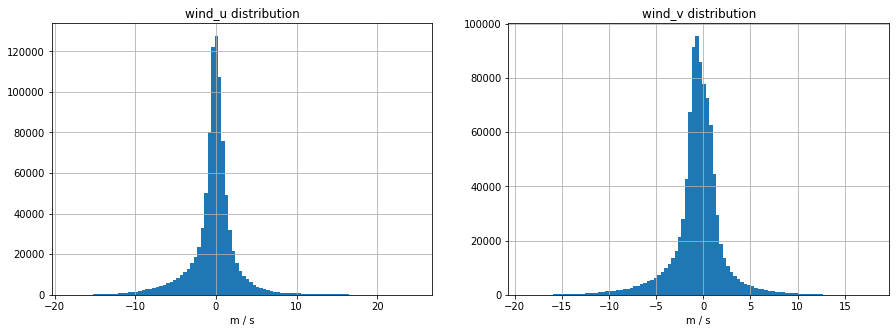

In [47]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2)

for iera5p , era5p in enumerate(['wind_u', 'wind_v']):
    axs[iera5p].hist(era5_eop.data[era5p].ravel(), bins=100);
    axs[iera5p].grid()
    axs[iera5p].set_title(f'{era5p} distribution')
    axs[iera5p].set_xlabel('m / s')

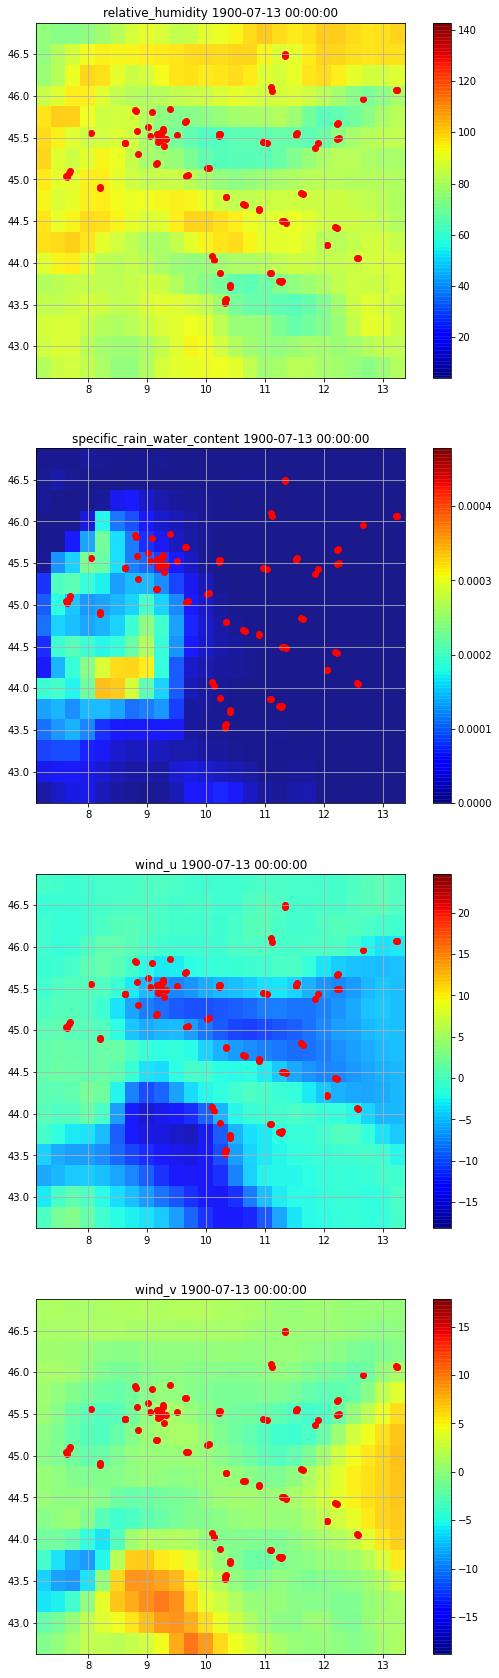

In [48]:
fig, axs = plt.subplots(figsize=(10, 30), nrows=len(era5_products))

time_idx = 0

normalisations = [dict(vmin=np.min(era5_eop.data[era5_p]), 
                       vmax=np.max(era5_eop.data[era5_p])) 
                  for era5_p in era5_products]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=era5_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])
    no2_gt_min.plot(ax=axs[nn], color='r', marker='o')
    

#### 1.3.4. Sentinel-3 <a name="sentinel-3"></a>

[Sentinel-3 Synergy](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-synergy) products are provided to characterise surface reflectance and aerosol parameters over land.

More information about the provided measurements can be found [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-syn).

The following variables are provided for each acquisition:

 * Aerosol Model Index Number (AMIN)
 * DEM-corrected longitude
 * DEM-corrected latitude
 * Aerosol Optical Thickness (AOT) at a wavelength of 550 nm (T550)
 * Error estimate of T550
 * Aerosol Angstrom coefficient (A550)
 * Status flag providing information about cloud, snow or land presence
 * alpha band, used to identify non-valid (e.g. unset/transparent) values

NOTE: The S3 tiles are loaded into separate eopatches for each timestamp due to small differences in bounding boxes, although they have same dimension. To correctly align their information, resampling to a common bounding box is required.

NOTE: Sentinel-3 data is not available for the South African AOI.

In [49]:
s3_train_dir = DATA_DIR/AOIS[0]/'SEN3'

s3_eops = [load_tiffs(datapath=s3_train_dir,
                      feature=(FeatureType.DATA, 'S3'),
                      filename=filename,
                      image_dtype=np.float32,
                      data_source='s3') 
           for filename in sorted(os.listdir(s3_train_dir))]

s3_eops[:3]

[EOPatch(
   data: {
     S3: numpy.ndarray(shape=(1, 1445, 2086, 8), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.021270651791451, 42.559159458180325), (13.603278291981102, 47.11860386857057)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 13, 9, 0)]
 ),
 EOPatch(
   data: {
     S3: numpy.ndarray(shape=(1, 1445, 2086, 8), dtype=float32)
   }
   mask: {}
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {}
   bbox: BBox(((7.02110144597423, 42.56013393605614), (13.603125402956803, 47.11958964930629)), crs=CRS('4326'))
   timestamp: [datetime.datetime(1900, 7, 15, 10, 0)]
 ),
 EOPatch(
   data: {
     S3: numpy.ndarray(shape=(1, 1445, 2086, 8), dtype=float32)
   }
   mask: {}
   scalar: {}
 

NOTE: check the data description for `NO_DATA_VALUE`

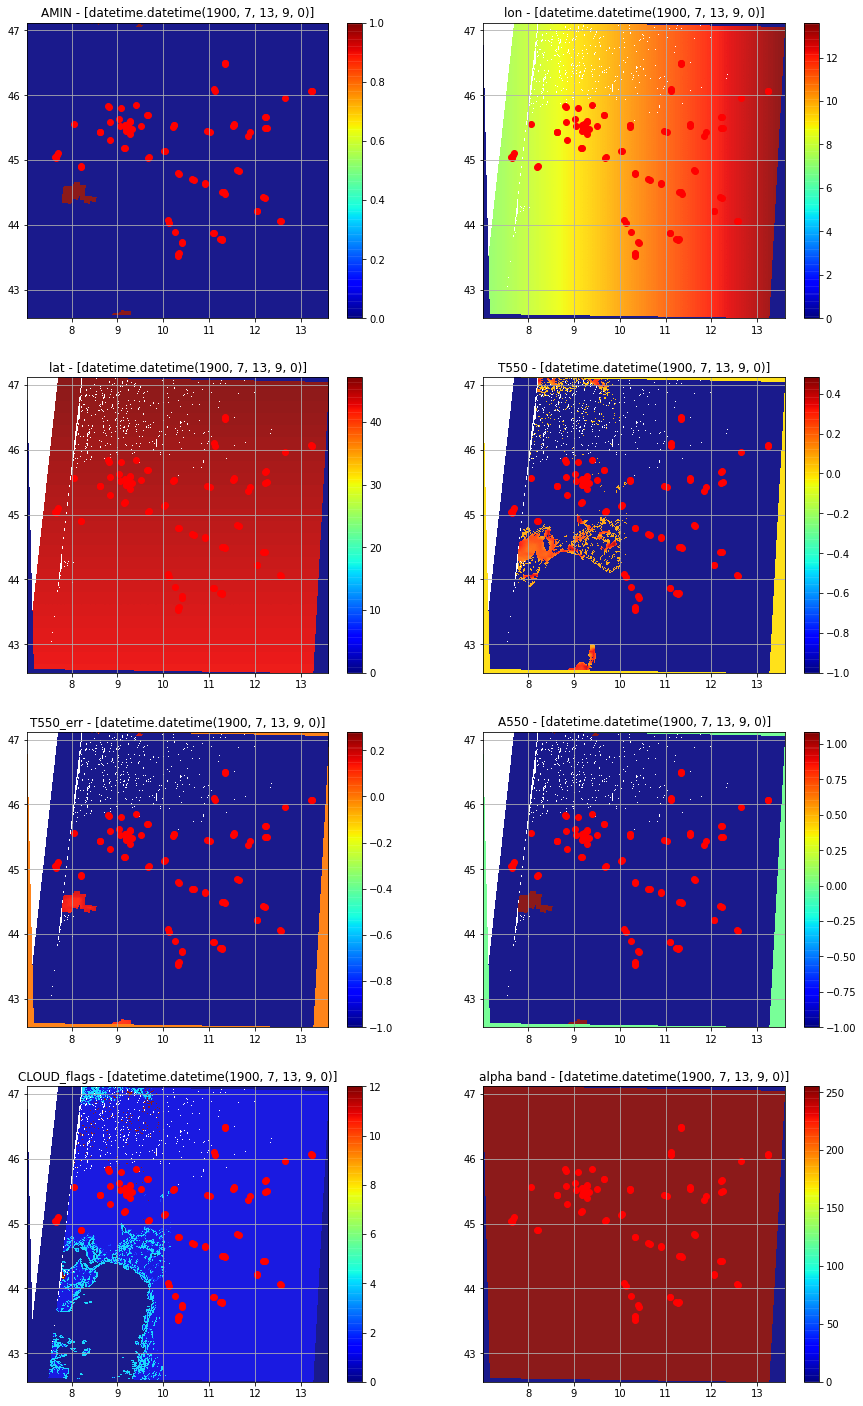

In [50]:
fig, axs = plt.subplots(figsize=(15, 25), nrows=4, ncols=2)

time_idx = 0

feature = s3_eops[time_idx].data['S3']

normalisations = [dict(vmin=np.nanmin(feature[0][..., band_idx]), 
                       vmax=np.nanmax(feature[0][..., band_idx])) 
                  for band_idx in range(8)]

for nn, (name, norms) in enumerate(zip(['AMIN', 'lon', 'lat', 'T550', 
                                        'T550_err', 'A550', 'CLOUD_flags', 
                                        'alpha band'], 
                                       normalisations)):
    fh = draw_feature(ax=axs[nn//2][nn%2], eopatch=s3_eops[time_idx], 
                      feature=(FeatureType.DATA, 'S3'),
                      time_idx=0, 
                      band=nn, **norms,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn//2][nn%2])
    axs[nn//2][nn%2].set_title(f'{name} - {s3_eops[time_idx].timestamp}')
    no2_gt_min.plot(ax=axs[nn//2][nn%2], color='r', marker='o')
    

#### 1.3.5. MODIS <a name="modis"></a>

[MODIS MCD19A2 products](https://lpdaac.usgs.gov/products/mcd19a2v006/) provide Aerosol Optical Depth (AOD) information over land.

The following layers are provided:

 * `Optical_Depth_047` Blue band (0.47 μm) AOD over land
 * `AOD_QA` Optical Depth Quality Index 
 
NOTE: Each tiff file has a different number of observations, depending on the orbit passes of the satellite. For this reason, temporal features cannot be concatenated into a single array. Here we load each timeframe separately. Statistics can be computed to derive a single daily observation, and daily observations can be merged into a single array at a later stage.

NOTE: check valid values for quality assurance values.

In [51]:
modis_train_dir = DATA_DIR/AOIS[0]/'modis_MCD19A2'

modis_products = sorted(os.listdir(modis_train_dir))
modis_products

['MCD19A2_AOD', 'MCD19A2_AOD_QA']

In [52]:
modis_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD',
                         feature=(FeatureType.DATA, 'AOD'),
                         filename=filename,
                         image_dtype=np.float32,
                         data_source='modis') 
              for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD'))]

In [53]:
modis_qa_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD_QA',
                            feature=(FeatureType.DATA, 'AOD_QA'),
                            filename=filename,
                            image_dtype=np.float32,
                            data_source='modis') 
                 for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD_QA'))]

In [54]:
len(modis_eops), len(modis_qa_eops)

(92, 92)

In [55]:
modis_eops[0]

EOPatch(
  data: {
    AOD: numpy.ndarray(shape=(1, 470, 679, 4), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((7.0250947874853615, 42.558244413729255), (13.60445942293717, 47.11244379320253)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 7, 13, 0, 0)]
)

In [56]:
modis_qa_eops[0]

EOPatch(
  data: {
    AOD_QA: numpy.ndarray(shape=(1, 470, 679, 4), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((7.0250947874853615, 42.558244413729255), (13.60445942293717, 47.11244379320253)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 7, 13, 0, 0)]
)

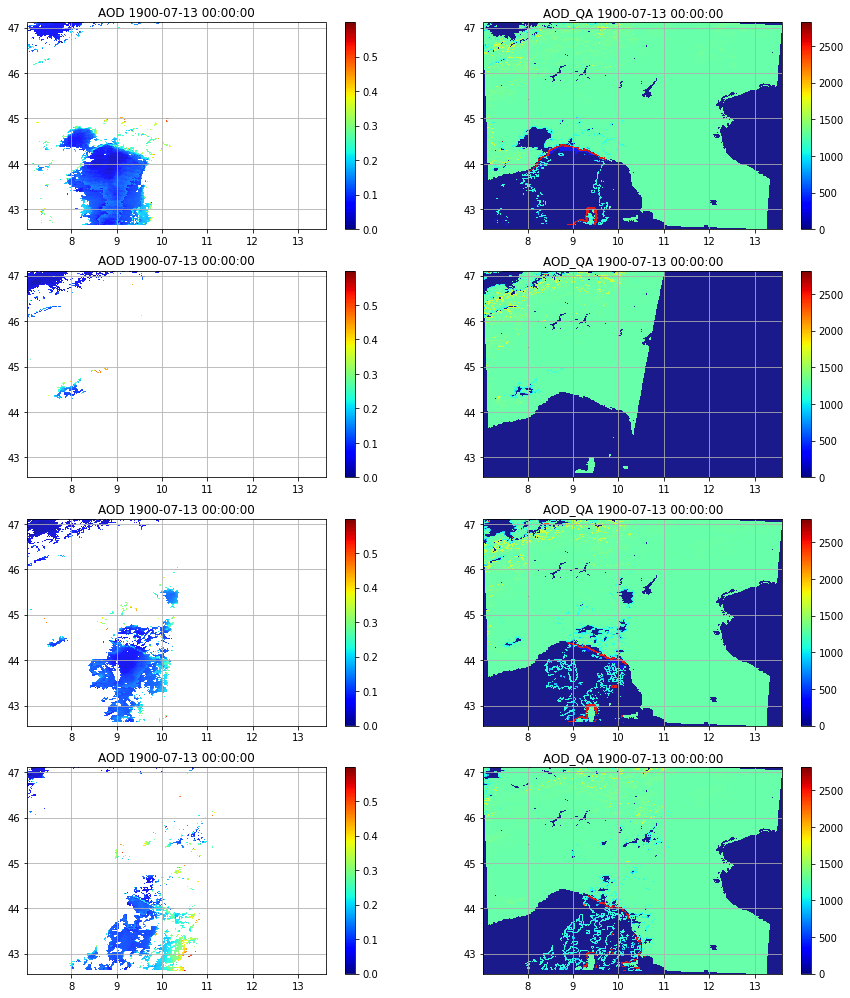

In [57]:
fig, axs = plt.subplots(figsize=(15,17.5), ncols=2, nrows=4)

time_idx = 0

aod = modis_eops[time_idx].data['AOD']
aod_qa = modis_qa_eops[time_idx].data['AOD_QA']

normalisation = [dict(vmin=np.nanmin(aod), vmax=np.nanmax(aod)),
                 dict(vmin=np.nanmin(aod_qa), vmax=np.nanmax(aod_qa))]

for band_idx in range(4):
    fh = draw_feature(ax=axs[band_idx%4][0], eopatch=modis_eops[time_idx], 
                      feature=(FeatureType.DATA, 'AOD'),
                      time_idx=0, **normalisation[0],
                      band=band_idx, 
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[band_idx%4][0])
    
    fh = draw_feature(ax=axs[band_idx%4][1], eopatch=modis_qa_eops[time_idx], 
                      feature=(FeatureType.DATA, 'AOD_QA'),
                      time_idx=0, **normalisation[1],
                      band=band_idx, 
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[band_idx%4][1])

## 2. Pre-processing <a name="pre-processing"></a>

Given the rich and diverse amount of data sources provided, you might encounter the following processing and analysis challenges:

 * data sources of different spatial and temporal resolution, and possibly different [Coordinate Reference Systems](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html) (CRS)s;
 * missing data and noisy time-series;
 * multi-variate analysis of different physical variables (be careful about the measurement units).

A possible way forward in `eo-learn` to retrieve all data sources for the reference locations could be:

 * bring all data sources to same CRS;
 * resample all data sources to same bounding box and spatial (target) resolution;
 * consider only days where reference data is provided. Merge measurements if hourly values are provided;
 * data sources can now be merged into a single `EOPatch` having same temporal and spatial dimensions;
 * add the reference vector data to the `EOPatch` and [rasterise](https://eo-learn.readthedocs.io/en/latest/eolearn.geometry.transformations.html#eolearn.geometry.transformations.VectorToRaster) it;
 * [sample](https://eo-learn.readthedocs.io/en/latest/eolearn.geometry.sampling.html#eolearn.geometry.sampling.PointSamplingTask) all data sources where reference raster is provided;
 * the time-series can be used for your modelling.
 
Here follows some pointers on how to achieve this. 

#### Warp all data to same CRS, e.g. land cover to wgs84

Check [rasterio's reprojection documentation](https://rasterio.readthedocs.io/en/latest/topics/reproject.html).

In [58]:
reproject_tiff(f'{land_cover_train_dir}/U2018_CLC2018_V2020_20u1_North_Italy.tif',
               f'{land_cover_train_dir}/land_cover.wgs84.tif', 
               dst_crs = 'EPSG:4326')

4088100.0 2167100.0 4595100.0 2671900.0


In [59]:
land_cover_eop_wgs84 = load_tiffs(datapath=land_cover_train_dir,
                                  feature=(FeatureType.MASK_TIMELESS, 'CORINE'), 
                                  filename=f'land_cover.wgs84.tif',
                                  image_dtype=np.uint8,
                                  no_data_value=128)

# set no label value to 0
array = land_cover_eop_wgs84.mask_timeless['CORINE']
land_cover_eop_wgs84.mask_timeless['CORINE'][array==128] = 0

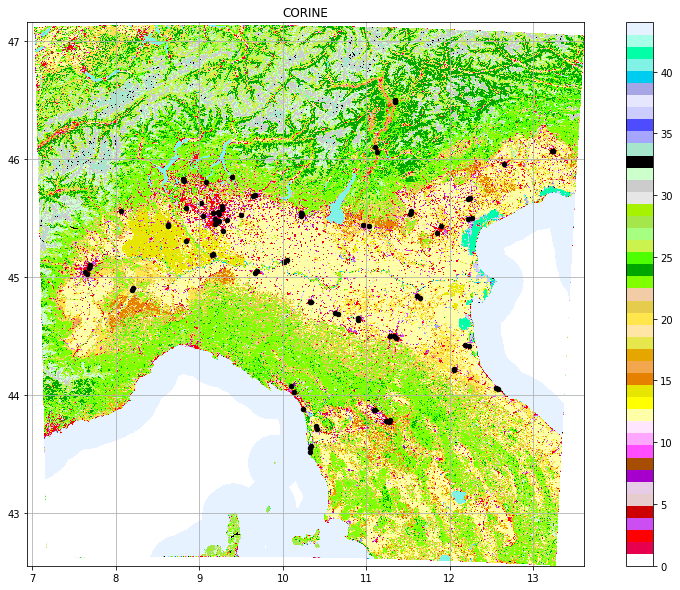

In [60]:
fig, ax = plt.subplots(figsize=(15,10))

fh = draw_feature(ax=ax, eopatch=land_cover_eop_wgs84, 
                 feature=(FeatureType.MASK_TIMELESS, 'CORINE'), 
                 time_idx=None, 
                 vmin=0, vmax=44, cmap=corine_cmap)

fig.colorbar(fh, ax=ax)

no2_gt_min.plot(ax=ax, color='k', marker='o', markersize=20);

#### Resample data sources to a common (target) grid

It can be useful to have all data sources in a common resampled grid, for instance at the target spatial resolution of 1km.

You can check out [this utility function](https://github.com/sentinel-hub/sentinelhub-py/blob/2a80df10c5a7acf85162dcc7f4f0cea7db5f246a/sentinelhub/geo_utils.py#L14) to calculate the size of the image in WGS84 with approximately a 1km spatial resolution, and code to resample an array to a new given shape (many options available in [rasterio](https://rasterio.readthedocs.io/en/latest/topics/resampling.html), [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize), [opencv](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#cv2.resize)). 

Pay attention to the resampling method (e.g. linear, nearest, bicubic) depending on the data source (e.g. use nearest for the categorical values of the land cover).

In [61]:
from sentinelhub import bbox_to_dimensions

Find dimension of an image of 1km spatial resolution using the Sentinel-5p bounding box

In [62]:
bbox_to_dimensions(s5p_eop.bbox, 1000)

(503, 504)

## 3. Submission example <a name="submission-example"></a>

The output of the challenge are predictions for NO2 and PM2.5 for some of the dates provided in the testing datasets.

The following provides an overview of a valid submission folder, which can be found in the datasets provided.

```
submission.zip
|── California
│   |── NO2
│   │    |── <date1>_NO2_California.tif
│   │    |── <date2>_NO2_California.tif
│   │    |── […]
│   │    └── <dateN>_NO2_California.tif
│   └── PM2.5
│         |── <date1>_PM25_California.tif
│         |── <date2>_PM25_California.tif
│         |── […]
│         └── <dateN>_PM25_California.tif
|── Italy
│   |── NO2
│   │    |── <date1>_NO2_Italy.tif
│   │    |── <date2>_NO2_Italy.tif
│   │    |── […]
│   │    └── <dateN>_NO2_Italy.tif
│   └── PM2.5
│        |── <date1>_PM25_Italy.tif
│        |── <date2>_PM25_Italy.tif
│        |── […]
│        └── <dateN>_PM25_Italy.tif
└── SouthAfrica
    |── NO2
    │    |── <date1>_NO2_SouthAfrica.tif
    │    |── <date2>_NO2_SouthAfrica.tif
    │    |── […]
    │    └── <dateN>_NO2_SouthAfrica.tif
    └── PM2.5
         |── <date1>_PM25_SouthAfrica.tif
         |── <date1>_PM25_SouthAfrica.tif
         |── […]
         └── <dateN>_PM25_SouthAfrica.tif
```

You will find the dates that need to be submitted for each AOI in provided metadata, as follows. 

Bounding boxes to be used for the predictions are provided for each of the three AOIs. The dimensions of the submitted files will correspond to the target resolution for the given AOI, which are:

 * approximately `500x500` pixels (i.e. `1kmx1km`) for Sentinel-5P NO2 product for the three AOIs,
 * approximately `500x500` pixels (i.e. `1kmx1km`) for CAMS PM2.5 product for Italy;
 * approximately `50x50` pixels (i.e. `10kmx10km`) for CAMS PM2.5 product for California and South Africa.

NOTE: these bounding boxes are in different CRSs than the provided data, so warping is necessary. You might want to reproject all the data to this CRS or WGS84 to ease the post-processing.

NOTE: set the following paths to the shapefiles defining the submission AOIs, and the dates used for validation/testing. One date file per product, i.e. `NO2` and `PM25` were created in this case.

In [63]:
bbox_ita = gpd.read_file('AOIs_bboxes/Italy/North_Italy_test.shp')

In [64]:
bbox_ita.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
dates_ita_no2 = pd.read_csv('Italy-date-NO2.txt')
dates_ita_no2

,Day,time
0,2295,h11
1,2300,h11
2,2306,h11
3,2315,h11
4,2323,h11
5,2328,h11
6,2332,h11
7,2339,h11
8,2344,h11
9,2350,h10


In [66]:
dates_ita_pm25 = pd.read_csv('Italy-date-PM25.txt')
dates_ita_pm25

,Day,time
0,2295,h12
1,2300,h12
2,2306,h12
3,2315,h12
4,2323,h12
5,2328,h12
6,2332,h12
7,2339,h12
8,2344,h12
9,2350,h12


Given the different spatial resolutions of the data sources, also the provided bounding boxes slightly differ.

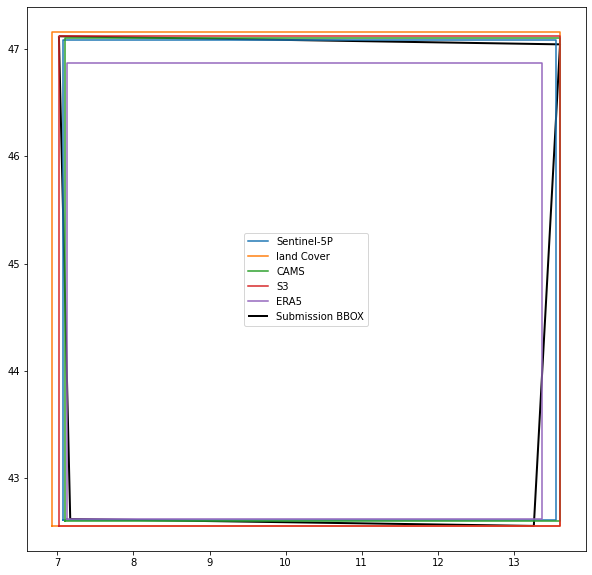

In [67]:
fig, ax = plt.subplots(figsize=(15,10))

for eop, name in [(s5p_eop, 'Sentinel-5P'), (land_cover_eop_wgs84, 'land Cover'), 
                  (cams_eop, 'CAMS'), (s3_eops[0], 'S3'), (era5_eop, 'ERA5')]:
    cx, cy = zip(*eop.bbox.get_polygon())
    
    ax.plot(cx, cy, label=name)

bbox_ita.to_crs(epsg=4326).boundary.plot(ax=ax, edgecolor='k', 
                                         linewidth=2, label='Submission BBOX')

ax.legend();

### 3.1 Prepare a submission <a name="prepare-a-submission"></a>

In the following we will prepare an example submission using bilinear interpolation of S5P `NO2` product and CAMS `PM2.5` product for North Italy. This represents a mock baseline for your algorithms.

The following code:

 * picks the test dates from the test datasets;
 * estimates the size of the resulting image given the target bounding box;
 * upscales the products to the target size;
 * removes values outside of the target bounding box.
 
NOTE: A valid entry has to include predictions for all three AOIs.

In [68]:
s5p_test_dir = Path('validation_dataset_ita/Italy/sentinel5P/NO2')

In [69]:
day, time = dates_ita_no2.iloc[0]

In [70]:
input_filename = f'S5P_NO2_OFFL_L2_day{day}_T{time.split("h")[-1]}.tif'
input_filename

'S5P_NO2_OFFL_L2_day2295_T11.tif'

In [71]:
test_img = load_tiffs(Path(s5p_test_dir), 
                      (FeatureType.DATA, 'NO2'), 
                      filename=input_filename)

In [72]:
target_resolution = 1000 # target resolution in metres

In [73]:
target_size = bbox_to_dimensions(test_img.bbox, target_resolution)
target_size

(508, 511)

In [74]:
# this function applies upscaling to first channel only, change if needed
upscale_tiff(s5p_test_dir/input_filename, 
             'TEST_S5P_NO2_OFFL_L2_day2295_T11.tif', 
             target_size)

bbox_ita.to_crs(epsg=4326, inplace=True)
bbox_ita.to_file('ita-bbox-wgs84.shp', driver='ESRI Shapefile')

mask_tiff('ita-bbox-wgs84.shp', 
         'TEST_S5P_NO2_OFFL_L2_day2295_T11.tif',
         'TEST_CROPPED_S5P_NO2_OFFL_L2_day2295_T11.tif')

In [75]:
upscaled_img = load_tiffs(Path('./'),
                          (FeatureType.DATA, 'NO2'),
                          filename='TEST_S5P_NO2_OFFL_L2_day2295_T11.tif')

cropped_img = load_tiffs(Path('./'),
                         (FeatureType.DATA, 'NO2'), 
                         filename='TEST_CROPPED_S5P_NO2_OFFL_L2_day2295_T11.tif')

In [76]:
test_img.data['NO2'].shape, upscaled_img.data['NO2'].shape

((1, 72, 104, 2), (1, 508, 511, 1))

Visualise original NO2 product (left), upscaled product (middle) and cropped product to the AOI bounding box (right).

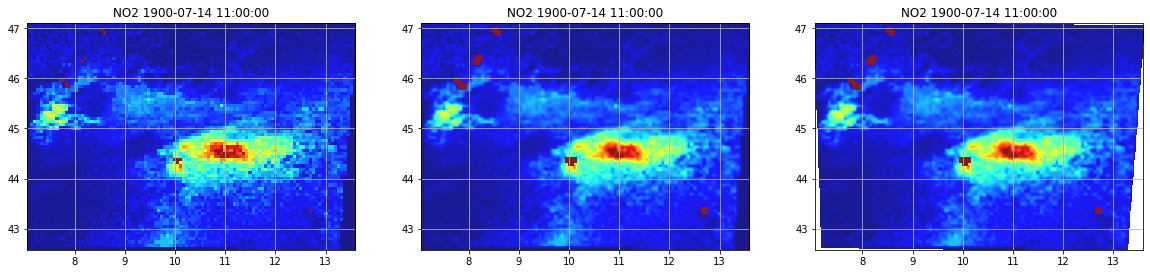

In [77]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3)

for nn, eop in enumerate([test_img, upscaled_img, cropped_img]):
    fh = draw_feature(ax=axs[nn], eopatch=eop, 
                      feature=(FeatureType.DATA, 'NO2'), 
                      band=0,
                      time_idx=0, vmin=0, vmax=0.0007,
                      alpha=.9, cmap=plt.cm.jet)


The following code prepares the submission files for the Italian AOI. 

NOTE: different target resolutions for PM2.5 are required for the different AOIs.

In [78]:
submission_dir = Path('test-submission')

for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)

NO2

In [79]:
for irow, row in dates_ita_no2.iterrows():
    day, time = row
    
    input_filename = f'S5P_NO2_OFFL_L2_day{day}_T{time.split("h")[-1]}.tif'
    
    # this function applies upscaling to first channel only, change if needed
    upscale_tiff(s5p_test_dir/input_filename, 
                 submission_dir/aoi/'NO2'/f'{day}_NO2_Italy.tif', 
                 target_size)

    mask_tiff('ita-bbox-wgs84.shp', 
              submission_dir/aoi/'NO2'/f'{day}_NO2_Italy.tif', 
              submission_dir/aoi/'NO2'/f'{day}_NO2_Italy.tif')

In [80]:
!ls {submission_dir/aoi/'NO2'}

2295_NO2_Italy.tif  2315_NO2_Italy.tif	2332_NO2_Italy.tif  2350_NO2_Italy.tif
2300_NO2_Italy.tif  2323_NO2_Italy.tif	2339_NO2_Italy.tif
2306_NO2_Italy.tif  2328_NO2_Italy.tif	2344_NO2_Italy.tif


PM2.5

In [81]:
cams_test_dir = Path('validation_dataset_ita/Italy/CAMS/PM2_5')

In [82]:
for irow, row in dates_ita_pm25.iterrows():
    day, time = row
    
    input_filename = f'CAMS_PM2_5_day{day}_{time.split(" ")[-1]}.tif'
    
    upscale_tiff(cams_test_dir/input_filename, 
                 submission_dir/aoi/'PM2.5'/f'{day}_PM25_Italy.tif', 
                 target_size)

    mask_tiff('ita-bbox-wgs84.shp', 
              submission_dir/aoi/'PM2.5'/f'{day}_PM25_Italy.tif', 
              submission_dir/aoi/'PM2.5'/f'{day}_PM25_Italy.tif')

In [83]:
!ls {submission_dir/aoi/'PM2.5'}

2295_PM25_Italy.tif  2323_PM25_Italy.tif  2344_PM25_Italy.tif
2300_PM25_Italy.tif  2328_PM25_Italy.tif  2350_PM25_Italy.tif
2306_PM25_Italy.tif  2332_PM25_Italy.tif
2315_PM25_Italy.tif  2339_PM25_Italy.tif
